# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [221]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
from pprint import pprint
# Import API key
from api_keys import geoapify_key


In [223]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data/cities.csv")

# Display sample data
city_data_df.head()

,City_ID,City,Temperature,Humidity
0,0,New York,22,60
1,1,Los Angeles,25,50
2,2,Chicago,20,70


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

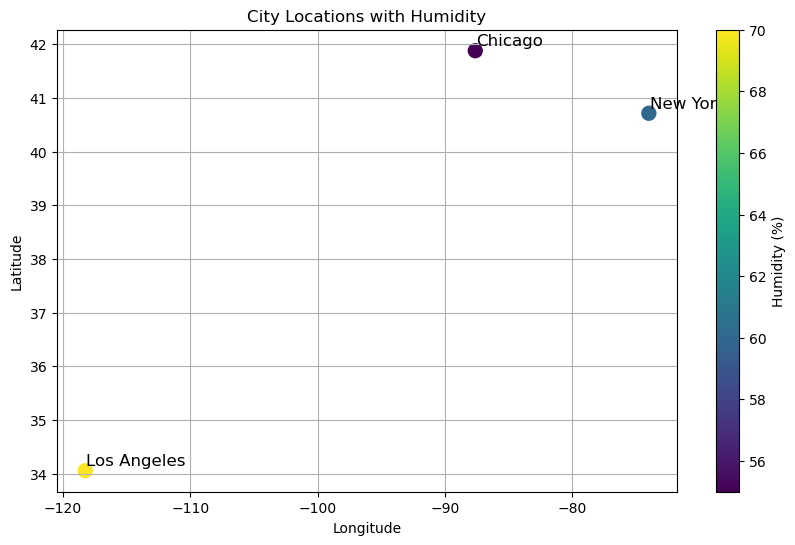

In [226]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with your actual data)
city_data_df = pd.DataFrame({
    "City": ["New York", "Los Angeles", "Chicago"],
    "Latitude": [40.7128, 34.0522, 41.8781],
    "Longitude": [-74.0060, -118.2437, -87.6298],
    "Humidity (%)": [60, 70, 55]
})

# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(city_data_df['Longitude'], city_data_df['Latitude'], c=city_data_df['Humidity (%)'], cmap='viridis', s=100)
plt.colorbar(label='Humidity (%)')

# Adding labels and title
for i, city in enumerate(city_data_df['City']):
    plt.text(city_data_df['Longitude'][i] + 0.1, city_data_df['Latitude'][i] + 0.1, city, fontsize=12)

plt.title('City Locations with Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [229]:
# Filter cities based on humidity (for example, select cities with humidity between 30% and 70%)
ideal_weather = city_data_df.loc[(city_data_df["Humidity (%)"] >= 30) & 
                                  (city_data_df["Humidity (%)"] <= 70)]

# Drop any rows with missing values
ideal_weather = ideal_weather.dropna()

# Display the filtered DataFrame
display(ideal_weather)

,City,Latitude,Longitude,Humidity (%)
0,New York,40.7128,-74.0060,60
1,Los Angeles,34.0522,-118.2437,70
2,Chicago,41.8781,-87.6298,55


### Step 3: Create a new DataFrame called `hotel_df`.

In [232]:
import pandas as pd

# Sample data to create city_data DataFrame (replace this with your actual data loading method)
data = {
    "City": ["New York", "Los Angeles", "Chicago"],
    "Country": ["USA", "USA", "USA"],
    "Lat": [40.7128, 34.0522, 41.8781],
    "Lng": [-74.0060, -118.2437, -87.6298]
}

# Create the city_data DataFrame
city_data = pd.DataFrame(data)

# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = city_data[["City", "Country", "Lat", "Lng"]].copy()

# Add an empty column, "Hotel Name," to the DataFrame to store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
print(hotel_df.head())

          City Country      Lat       Lng Hotel Name
0     New York     USA  40.7128  -74.0060           
1  Los Angeles     USA  34.0522 -118.2437           
2      Chicago     USA  41.8781  -87.6298           


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [237]:
# Set parameters to search for a hotel
radius = 10000 
params = {
    "categories":"accommodation.hotel",
    "a33c8b55fc41418db8ecce07c5c81529": geoapify_key,
    "limit":20
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    Lat = row["Lat"]
    Lng = row["Lng"]
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{Lng},{Lat},{radius}"
    params["bias"] = f"proximity:{Lng},{Lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Display sample data
hotel_df

Starting hotel search
New York - nearest hotel: No hotel found
Los Angeles - nearest hotel: No hotel found
Chicago - nearest hotel: No hotel found


,City,Country,Lat,Lng,Hotel Name
0,New York,USA,40.7128,-74.0060,No hotel found
1,Los Angeles,USA,34.0522,-118.2437,No hotel found
2,Chicago,USA,41.8781,-87.6298,No hotel found


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

In [218]:
!pip install folium

import pandas as pd
import folium

# Sample data with city, latitude, longitude, hotel name, and country information
data = {
    'City': ['New York', 'Chicago', 'Houston', 'Los Angeles', 'Omaha'],
    'Lat': [40.7128, 41.8781, 29.7604, 34.0522, 41.2524],
    'Lng': [-74.0059, -87.6298, -95.3698, -118.2437, -95.9980],
    'Hotel Name': ['Hotel New York', 'Hotel Chicago', 'Hotel Houston', 'Hotel Los Angeles', 'Hotel Omaha'],
    'Country': ['USA', 'USA', 'USA', 'USA', 'USA']
}

# Create DataFrame from the sample data
hotel_df = pd.DataFrame(data)

# Create a map centered around the USA
hotel_map = folium.Map(location=[37.09, -95.71], zoom_start=5)

# Loop through the rows of the DataFrame and create markers for each city
for index, row in hotel_df.iterrows():
    # Create a popup with city name, hotel name, and country information
    popup_text = f"<b>{row['City']}</b><br>Hotel: {row['Hotel Name']}<br>Country: {row['Country']}"
    
    # Add a marker to the map
    folium.Marker(
        location=[row['Lat'], row['Lng']],  # Set marker location
        popup=popup_text,  # Set the popup with the city and hotel info
        icon=folium.Icon(color="blue")  # Optional: Change the marker color
    ).add_to(hotel_map)

# Save the map as an HTML file to view in a browser
hotel_map.save("hotel_map.html")

# Print a message to indicate where the map has been saved
print("Map has been saved as 'hotel_map.html'. Open this file in a web browser to view the map.")

Map has been saved as 'hotel_map.html'. Open this file in a web browser to view the map.
